## Exploring wrangled data from the Animal Shelter.

* The main goal is to find out what if anything helps increase animal adoptions based on the basic intake data recorded by most animal shelters.
* We can also get sense of the intakes and outtakes demographics that go in and out of the shelter.
    * This can help in understanding if there is an imbalance in the dogs that get adopted versus those that do not.
    * In this way, we can better understand and educate people on which dogs may need more help and more love.

****

In [1]:
#first import the packages needed.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt

#set max rows of pandas to display to 1000
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

#now import the data
dogs_join = pd.read_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_join.csv', encoding='latin-1')

C:\Users\sethh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
print(dogs_join.head(5))

  animal_id datetime_in intake_condition      intake_type name_in    color1  \
0   A006100  2014-03-07           Normal    Public Assist   Scamp    Yellow   
1   A006100  2014-12-19           Normal    Public Assist   Scamp    Yellow   
2   A006100  2017-12-07           Normal            Stray   Scamp    Yellow   
3   A047759  2014-04-02           Normal  Owner Surrender    Oreo  Tricolor   
4   A134067  2013-11-16          Injured    Public Assist  Bandit     Brown   

  color2  intake_age found_loc intake_sex intake_fixed             breed1  \
0  White        72.0    Austin       Male     Neutered   Spinone Italiano   
1  White        84.0    Austin       Male     Neutered   Spinone Italiano   
2  White       120.0    Austin       Male     Neutered   Spinone Italiano   
3   None       120.0    Austin       Male     Neutered          Dachshund   
4  White       192.0    Austin       Male     Neutered  Shetland Sheepdog   

  breed2  intake datetime_out name_out outcome_subtype     out

### 1) Now let's look at the adoptions as a whole
* a) Look at the categories of outtake types.
* b) Look at adoptions over time.
* c) Look at time to adoption distribution for adoption outcomes.
    * Break into categories for time to adoption analysis later on.

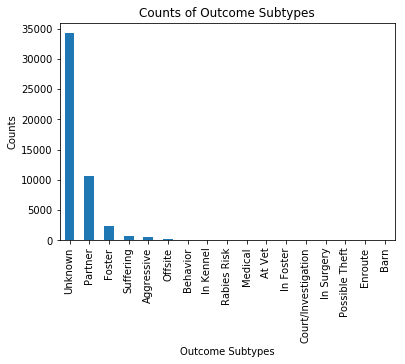

Unknown                34233
Partner                10549
Foster                  2392
Suffering                710
Aggressive               489
Offsite                  257
Behavior                 132
In Kennel                103
Rabies Risk               85
Medical                   63
At Vet                    33
In Foster                 22
Court/Investigation       22
In Surgery                 7
Possible Theft             7
Enroute                    6
Barn                       1
Name: outcome_subtype, dtype: int64


In [3]:
#a. get value_counts of the outcome_type unique values.
#first look to see if the data in the outcome_subtype series provides that much information.
subtypes = dogs_join.outcome_subtype.value_counts()
subtypes.plot(kind='bar')
plt.xlabel('Outcome Subtypes')
plt.ylabel('Counts')
plt.title('Counts of Outcome Subtypes')
plt.show()
print(subtypes)
#The majority of the subtypes are unknown.  So, let's just focus on the type.

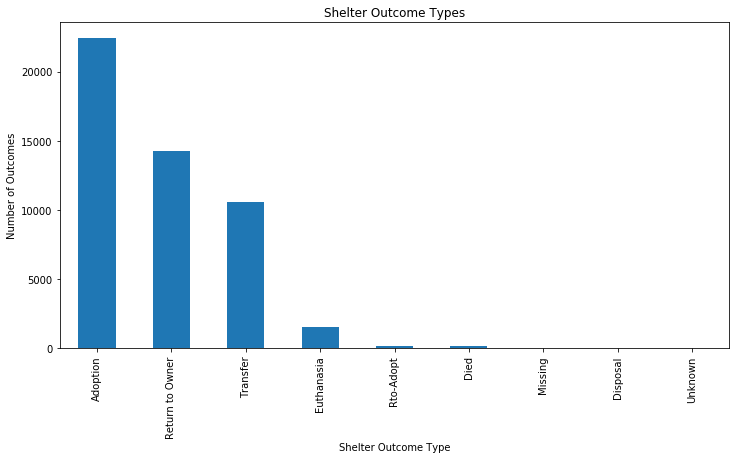

Adoption           22435
Return to Owner    14231
Transfer           10550
Euthanasia          1521
Rto-Adopt            185
Died                 159
Missing               17
Disposal              10
Unknown                3
Name: outcome_type, dtype: int64


In [4]:
#now get a distribution of outcome types
out_types = dogs_join.outcome_type.value_counts()
plt.figure(figsize=(12,6))
out_types.plot(kind='bar')
plt.title('Shelter Outcome Types')
plt.xlabel('Shelter Outcome Type')
plt.ylabel('Number of Outcomes')
plt.show()
print(out_types)

It seems that the most common outcome types are adoptions or return to owner which is good for the dogs as this means they now have a home.  More attention will be paid a little later into the stats behind the adopted vs. animals that leave the shelter in less fortunate means.

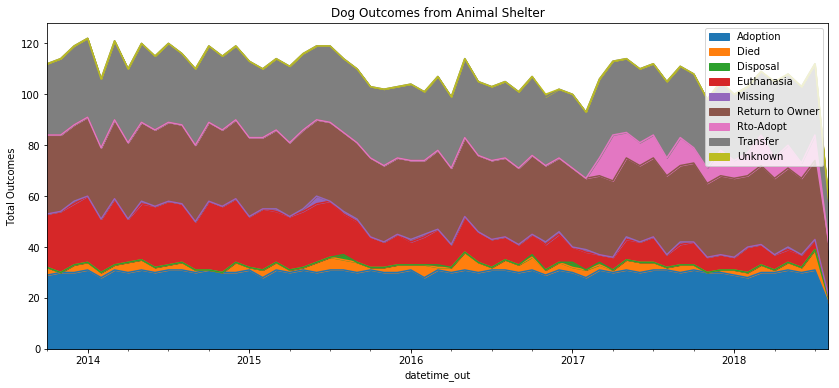

In [5]:
#b. let's look at adoptions over time.  This will be a surface glance, not taking into account multiple adoptions etc.
#organize dogs_join by datetime_out as the index
dogs_join_time = dogs_join.set_index('datetime_out', drop=True)

#sort by index
dogs_join_time = dogs_join_time.sort_index()

#break out each outcome type over time to get a graph stacked by outcome type
dogs_by_type = pd.pivot_table(dogs_join_time, values='intake_condition', columns='outcome_type', aggfunc='count', 
                              index=dogs_join_time.index)
dogs_by_type.index = pd.to_datetime(dogs_by_type.index)

#resample by month then plot a stacked area plot
dogs_by_type = dogs_by_type.resample('M').count()
dogs_by_type.plot(kind='area', stacked=True, figsize=(14,6))

#calculate the x labels and format the plot
#x_labels = [date.strftime('%B %Y') for date in dogs_by_type.index]
plt.title('Dog Outcomes from Animal Shelter')
plt.ylabel('Total Outcomes')
plt.legend(loc='best')
plt.show()

* There seems to be about 30 adoptions a month or one a day, which is quite steady.
    * There seems to also be a dip in adoptions in the spring time around February/March of each year.
* With another 30-50 as return to owner/return to owner-adopt, this leaves about 40-60 dogs that could have had better outcomes.
* Transfers to other shelters (which is better but not counted as adopted) remain pretty steady as well at about 30 per month.  Cutting out transfers by increasing direct adoptions from the shelter would reduce strain and resources of the other animal shelters and adoption organizations etc..  This reduces overall cost that goes into the adoption process and gets a dog to happy home quicker.
* Died, Disposal, and Missing thankfully remain consistently low.
* Euthanasia dropped by about half from 30 to 10-15 per month around October-November 2015, and seems to be gradually decreasing over time, which is great.

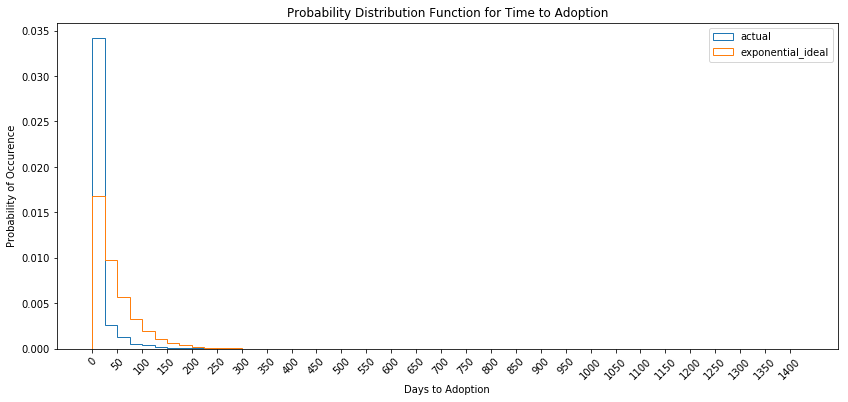

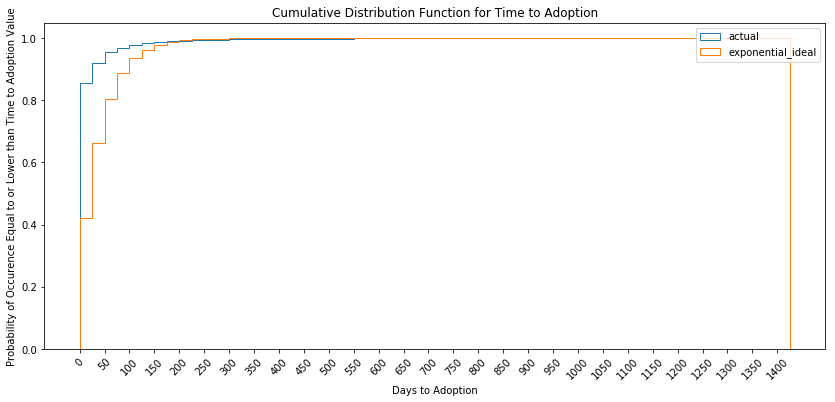

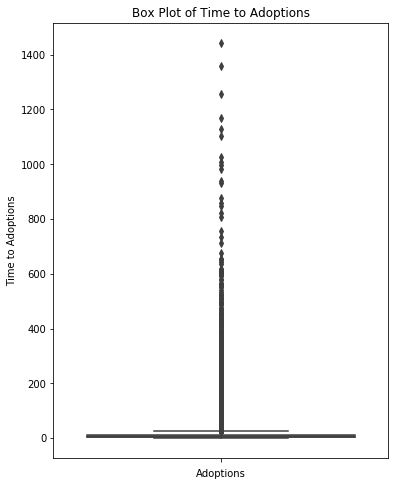

In [6]:
#c look at the distribution of time to adoption values (for adoption and return to owner values only)
time_to_adopt = dogs_join_time.loc[(dogs_join_time.outcome_type == 'Adoption') |
                                   (dogs_join_time.outcome_type == 'Return to Owner') | 
                                   (dogs_join_time.outcome_type == 'Rto-Adopt')]['shelter_time']

#set bins for histograms
bins=range(0,round(int(time_to_adopt.max())),25)

#first with a pdf
plt.figure(figsize=(14,6))
time_to_adopt.plot(kind='hist', bins=bins, normed=True, histtype='step', label='actual')
plt.xlabel('Days to Adoption')
plt.ylabel('Probability of Occurence')
plt.title('Probability Distribution Function for Time to Adoption')
plt.xticks(range(0,round(int(time_to_adopt.max())),50), rotation=45)

#overlay exponential distribution
std_dev = np.std(time_to_adopt)
exp_distr = np.random.exponential(scale=std_dev, size=len(dogs_join.shelter_time))
plt.hist(exp_distr, histtype='step', normed='True', bins=bins, label='exponential_ideal')
plt.legend(loc='best')
plt.show()

#second with a cdf
plt.figure(figsize=(14,6))
time_to_adopt.plot(kind='hist', bins=bins, normed=True, histtype='step', cumulative=True, label='actual')
plt.xlabel('Days to Adoption')
plt.ylabel('Probability of Occurence Equal to or Lower than Time to Adoption Value')
plt.title('Cumulative Distribution Function for Time to Adoption')
plt.xticks(range(0,round(int(time_to_adopt.max())),50), rotation=45)

#overlay exponential distribution
plt.hist(exp_distr, histtype='step', normed=True, cumulative=True, bins=bins, label='exponential_ideal')
plt.legend(loc='best')
plt.show()

#box plot to visualize data spread and outliers
plt.figure(figsize=(6,8))
sns.boxplot(x=time_to_adopt, orient='v')
plt.xlabel('Adoptions')
plt.ylabel('Time to Adoptions')
plt.title('Box Plot of Time to Adoptions')
plt.show()

* The distribution of time to adoption values seems to be exponential in nature but skewed from the ideal distribution.
* 95% probability that an adoption will occur in approximately 50 days or less.
    * This agrees quite well with the steady adoption rate of 30 per month.
    * Based on this I think we can break the time to adoption categories into groups for categorical prediction and analysis later on.
        * The first group being adopted in 7 days (1 week) or less.
        * The second group being 8 - 21 days (3 weeks).
        * The third group being 22 - 50 days (7 weeks).
        * The last group being 50+ days (outliers).
* There are outliers in the time to adoption that have taken up to 1400 days or almost 4 years to be adopted.
    * I see no evidence in the data given not to trust this as a real number.  So I will keep the outliers.
    
*****

## 2) Let's look into the intake data.
* Knowing the basic statistics such as the ones listed below for the intake dogs will allow the shelter to better understand its intake base.  This is valuable information as the shelter can better understand the demographic of its population and target their focus in marketing and adoption efforts on the right crowds for the dogs that they have the most of.  This is not the whole picture.  However, this information when combined with the outtake data will give a basis to check for trouble areas when it comes to getting these dogs to a good home.
* Break down the intakes by dog features and get the basic statistics.
    * a) Breeds 
        * Primary (Top 10)
        * Secondary (Top 10)
    * b) Age (Distribution)
    * c) Color
        * Primary (Top 10)
        * Secondary (Top 10)
    * d) Gender (Comparison)
    * e) Fixed (Comparison)
    * f) Intake Condition (Comparison)
    * g) Intake Type (Comparison)
    
*****

**a) Breeds**
* Primary
    * Top 10
* Secondary
    * Distribution

In [7]:
#create top 10 function
def top10(series):
    """
    Takes a series and returns the top 10 descending value counts from the series.
    """
    try: 
        sort = series.value_counts().sort_values(ascending=False)
        return(sort.head(10))
    except:
        print('Series not in the dataframe.')


In [8]:
#a) Breeds.  Separate and count intakes by breeds.
top10_prim = top10(dogs_join.breed1)
print('The top 10 primary intake breeds are:\n{}'.format(top10_prim))

#now for the top secondary breeds
print()
top10_sec = top10(dogs_join.breed2)
print('The top 10 secondary intake breeds are:\n{}'.format(top10_sec))

#calculate % of total intakes that have secondary breed of Mix or none
print()
print('The % of total intakes that have secondary breed of Mix or None is {}.'.format(100*(top10_sec[0]+top10_sec[1])/
                                                                                      len(dogs_join.animal_id)))

The top 10 primary intake breeds are:
Pit Bull                 7539
Labrador Retriever       6906
Chihuahua Shorthair      6180
German Shepherd          2896
Australian Cattle Dog    1553
Dachshund                1326
Boxer                    1035
Border Collie            1017
Miniature Poodle          892
Beagle                    712
Name: breed1, dtype: int64

The top 10 secondary intake breeds are:
Mix     46143
None     3421
Name: breed2, dtype: int64

The % of total intakes that have secondary breed of Mix or None is 100.0.


* It seems that the 84% of the secondary breed data fits into 2 categories: Mix and None.
* Very few of the mixed are labeled with a second breed.
    *  More breed data would definitely help with more accurate analysis and predictions.
    *  I'm limited to what the data says.  The accuracy of the breed identifications is unknown.
    *  It's probably okay to just lump the remaining breeds that are not "None" into the "Mix" label without causing too many issues.

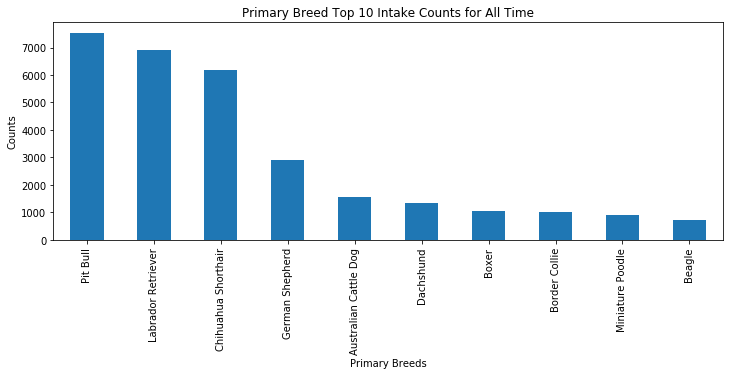

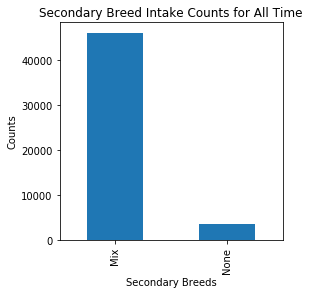

In [9]:
#lump secondary breed into Mix or None
for index, row in dogs_join.iterrows():
    if (row['breed2'] != 'Mix') & (row['breed2'] != 'None'):
        dogs_join.loc[index, 'breed2'] = 'Mix'
        
#plot top10 of each
plt.figure(figsize=(12,4))
top10_prim.plot(kind='bar')
plt.xlabel('Primary Breeds')
plt.ylabel('Counts')
plt.title('Primary Breed Top 10 Intake Counts for All Time')
plt.show()

#recalculate the cats for secondary
plt.figure(figsize=(4,4))
dogs_join.breed2.value_counts().plot(kind='bar')
plt.xlabel('Secondary Breeds')
plt.ylabel('Counts')
plt.title('Secondary Breed Intake Counts for All Time')
plt.show()

* The most popular breed taken in is pit bull which from my limited experience with dog shelters seems to be the case.
* Also, for machine learning application, I will use this modified secondary breed information.
* Does being a certain breed help in getting adopted faster or having a higher adoption percentage?
    * A question for the statistical analysis section to come in a subsequent notebook.
* Knowing the top breeds in the shelter can help the shelter in determining the right marketing strategy and target audience for any adoption events that they could potentially have or are already conducting.

*****

**b) Age Upon Intake**
* Distribution

Summary Statistics for Intake Age
count    49564.000000
mean        32.056436
std         36.497696
min          0.000000
25%          8.000000
50%         24.000000
75%         36.000000
max        288.000000
Name: intake_age, dtype: float64


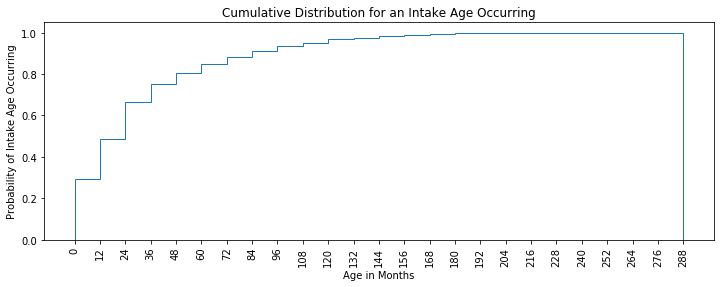

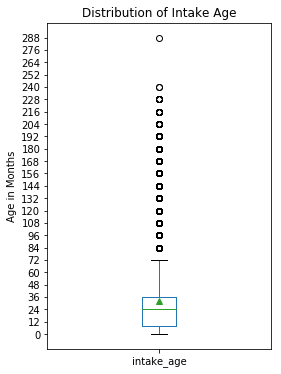

In [10]:
#get the ages and plot the distribution
#need to find min and max age etc.
ages = dogs_join.intake_age
print('Summary Statistics for Intake Age')
print(ages.describe())

#plot the distribution
#cdf
plt.figure(figsize=(12,4))
ages.plot(kind='hist', normed = True, cumulative=True, histtype='step', bins=range(0,int(ages.max())+12,12))
plt.xlabel('Age in Months')
plt.ylabel('Probability of Intake Age Occurring')
plt.xticks(range(0,int(ages.max())+12,12), rotation=90)
plt.title('Cumulative Distribution for an Intake Age Occurring')
plt.show()

#plot boxplot
plt.figure(figsize=(4,6))
ages.plot(kind='box', showmeans=True)
plt.ylabel('Age in Months')
plt.yticks(range(0,int(ages.max())+12,12))
plt.title('Distribution of Intake Age')
plt.show()

* 80% of the dogs that come in are 5 years old or less, which is middle age for a dog.
* There are some outliers in the age of the dogs out there just as there are some really old humans.  A 24 year old dog may be a typo but there are some dogs in the shelter at 20 years old which is believable, and doesn't make the 24 years seem absurd.
* Do younger dogs (puppies) get adopted sooner or more in general?
    * A question we can answer in the statistical analysis section.

****

**c) Color**
* Primary
    * Top 10
* Secondary
    * Top 10

In [11]:
#get color one and color two into series
color1 = dogs_join.color1
color2 = dogs_join.color2

#now order and get primary top 10
top_prim_color = top10(color1)
print('The top 10 primary colors are:\n{}'.format(top_prim_color))

#now for the secondary top 10
print()
top_sec_color = top10(color2)
print('The top 10 secondary colors are:\n{}'.format(top_sec_color))

The top 10 primary colors are:
Black            12756
White             8836
Brown             6341
Tan               5914
Brown Brindle     2320
Tricolor          2231
Red               2167
Blue              1901
Chocolate         1279
Sable              769
Name: color1, dtype: int64

The top 10 secondary colors are:
White            17723
None             17069
Tan               4200
Black             4183
Brown             3607
Brown Brindle      492
Tricolor           453
Gray               382
Red                307
Cream              239
Name: color2, dtype: int64


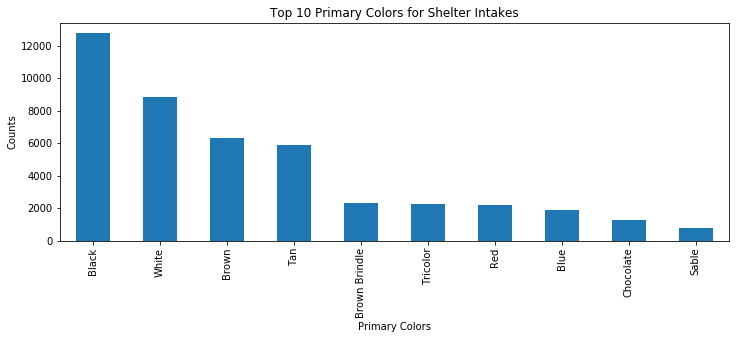

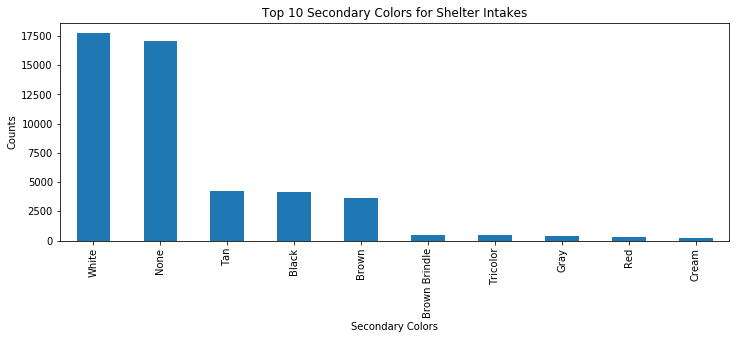

In [12]:
#plot the top 10s
#primary colors
plt.figure(figsize=(12,4))
top_prim_color.plot(kind='bar')
plt.xlabel('Primary Colors')
plt.ylabel('Counts')
plt.title('Top 10 Primary Colors for Shelter Intakes')
plt.show()

#secondary colors
plt.figure(figsize=(12,4))
top_sec_color.plot(kind='bar')
plt.xlabel('Secondary Colors')
plt.ylabel('Counts')
plt.title('Top 10 Secondary Colors for Shelter Intakes')
plt.show()

* It looks like the top colors in general are black and white.
* The top secondary color is white or none with trace amounts of other colors.
    * Does having a secondary color make the dog more adoptable?  
        * Something to look at and answer in the statistics section.
        
*****

**d) Gender**
* Comparison

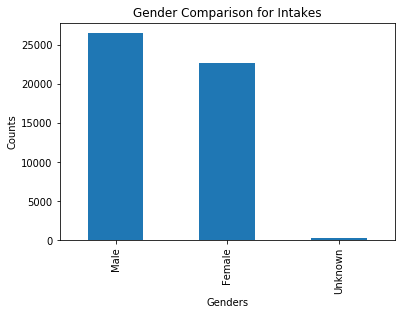

In [13]:
#separate Gender series
genders = dogs_join.intake_sex

#plot the value counts
plt.figure(figsize=(6,4))
genders.value_counts().plot(kind='bar')
plt.xlabel('Genders')
plt.ylabel('Counts')
plt.title('Gender Comparison for Intakes')
plt.show()

* There are more intakes that are males than females, but the ratio is roughly 50/50.  
* There are a small amount of unknowns which is probably missing data.
* Does one gender get adopted at a higher percentage/quicker than the other?
    * A question for the statistical analysis section.
    
*****

**e)Fixed**
* Comparison

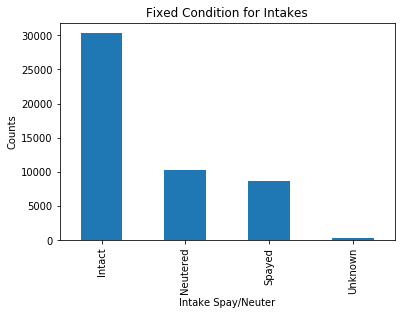

In [14]:
#isolate fixed series
fixed = dogs_join.intake_fixed

#plot the value counts
plt.figure(figsize=(6,4))
fixed.value_counts().plot(kind='bar')
plt.xlabel('Intake Spay/Neuter')
plt.ylabel('Counts')
plt.title('Fixed Condition for Intakes')
plt.show()

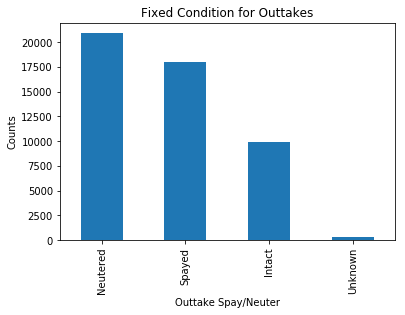

In [15]:
#let's compare this to the outtake fixed data
out_fix = dogs_join.outtake_fixed

#plot the value counts
plt.figure(figsize=(6,4))
out_fix.value_counts().plot(kind='bar')
plt.xlabel('Outtake Spay/Neuter')
plt.ylabel('Counts')
plt.title('Fixed Condition for Outtakes')
plt.show()

* It seems that the majority (roughly 2/3) of the pets in the shelter that come in intact leave spayed or neutered.  This is good for population control.
* Most of the intakes are intact, while most of the outcomes are fixed.
* Does being fixed lead to being more adoptable or getting adopted quicker?
    * A question for the statistical analysis section.
* More questions that could be investigated or cross correlations between sex and fixed state and adoptability, but due to lack of time, these won't be answered presently.

*****

**f) Intake Condition**
* Comparison

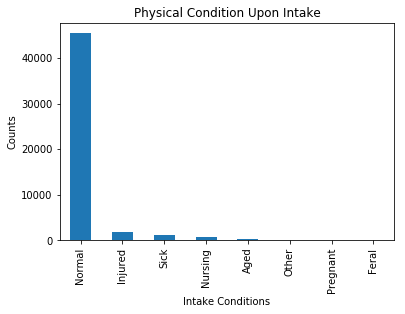

In [16]:
#get intake condition as a Series
intake_conditon = dogs_join.intake_condition

#plot the value counts
plt.figure(figsize=(6,4))
intake_conditon.value_counts().plot(kind='bar')
plt.xlabel('Intake Conditions')
plt.ylabel('Counts')
plt.title('Physical Condition Upon Intake')
plt.show()

* The vast majority of the intakes come in in normal condition.
    * Any statistics here would be skewed by the huge weight to the Normal grouping.

*****

**g) Intake Type**
* Comparison
* Percent of euthanasia outcomes that were requested upon intake
* Percnet of return to owner outcomes that originated as owner surrenders.

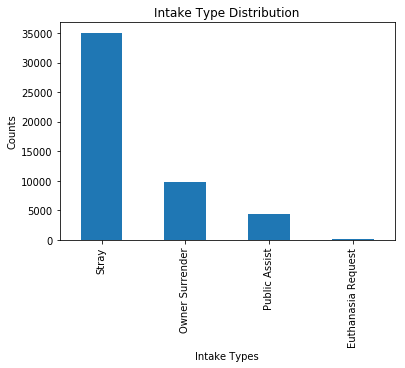


The percent of Euthanasia outcomes that were requested upon intake is 9.6.
The percent of Return to Owner outcomes that originated as Owner Surrenders is 4.4.


In [17]:
#get intake type as a Series
intake_type = dogs_join.intake_type

#plot the value counts
plt.figure(figsize=(6,4))
intake_type.value_counts().plot(kind='bar')
plt.xlabel('Intake Types')
plt.ylabel('Counts')
plt.title('Intake Type Distribution')
plt.show()

#let's calculate the percent of euthanasia outcomes that were requested
euthanasias = len(dogs_join.loc[dogs_join.outcome_type=='Euthanasia'])
euth_req = len(dogs_join.loc[(dogs_join.outcome_type=='Euthanasia') & (dogs_join.intake_type=='Euthanasia Request')])
print()
print('The percent of Euthanasia outcomes that were requested upon intake is {}.'.format(round((euth_req/euthanasias)*100,1)))

#let's calculate the percent of return to owner outcomes that were originally Owner surrender
owner_returns = len(dogs_join.loc[(dogs_join.outcome_type=='Return to Owner') | (dogs_join.outcome_type=='Rto-Adopt')])
surrenders = len(dogs_join.loc[((dogs_join.outcome_type=='Return to Owner') | (dogs_join.outcome_type=='Rto-Adopt')) 
                               & (dogs_join.intake_type=='Owner Surrender')])
print('The percent of Return to Owner outcomes that originated as Owner Surrenders is {}.'.format(
    round((surrenders/owner_returns)*100,1)))

* The majority of intakes are strays.
* Two interesting stats arose:
    * Most of the Euthanasia outcomes are not from requests upon intake, suggesting most of the dogs that are euthanized are not done at the owners request.
        * This is intriguing as the shelter is supposed to be no kill.  This could be due to poor record keeping as well.
    * Most owner surrenders are not returned to the owners, suggesting that one should probably not use the animal shelter as a form of free animal boarding to be on the safe side.
        * Once again, these numbers assume that most if not every owner surrender is meant to be a return to owner outtake.
    
*****

## 3. Quick look at Intake Feature Correlations to Adoptions
* Let's stick with the most interesting features that aren't heavily weighted to one feature grouping.
    * Thus we are dropping intake_type and intake_condition from this step.
* We will look at the percent adoptions multiplied by the total number of adoptions for each category grouping (weighted adoption count).
    * For example, percent of Pitbulls adopted would be the number of Pitbulls adopted/total number of Pitbulls in outtakes.
    * This percent adopted will be multiplied by the number of Pitbulls adopted to produce the weighted adoption count for Pitbulls.
        * This will hopefully give an idea of the efficiency and quantity of the adoptions in each category grouping.
* We will also look at median time to adoption for the different category groupings.
* This information regarding how the intake features may or may not affect the Adoption percentages and time to adoptions will aid in identifying good and troublesome areas and dogs in the adoption process.  This could lead to direction of efforts (whether that be marketing, increased animal care, etc.) to certain dogs that statistically need more help to be adopted more efficiently and quicker.  This can save the shelter time and increase the turnover rate for adoptions which is a win win situation for the shelter, surrounding animal homes, the potential adopters, and the potential adoptees.
* Following the same flow as the previous section for intake features/category groupings.
    * a) Breeds 
        * Primary (Top 10)
        * Secondary (Comparison)
    * b) Age (Distribution)
    * c) Color
        * Primary (Top 10)
        * Secondary (Top 10)
    * d) Gender (Comparison)
    * e) Fixed (Comparison)
    * f) Seasons (Comparison)
    
*****

### First we need to define functions. 
* The first function to group the dataframe by time to adoption will come in handy in labeling in the machine learning step later.

**The different time to adoption groups are:** 
* The first being adopted in 7 days (1 week) or less.
* The second being 8 - 21 days (3 weeks).
* The third being 22 - 50 days (7 weeks).
* The last being 50+ days (outliers).

In [18]:
#define the function 
def tta_grouper(df, tta_cat=1):
    """
    Takes a df and filters based on a desired time to adoption window.
    tta_cat values: 1 = 7 days or less, 2 = 8-21 days, 3 = 22 - 50 days, 4 = 50+ days
    """
    #define dictionary to store category details
    cats = {1: [0,7], 2: [8,21], 3: [22,50], 4: [0, np.inf]}
    
    #filter df column for the chosen category values
    df_filtered = df.loc[(df['shelter_time'] >= cats[tta_cat][0]) & (df['shelter_time'] <= cats[tta_cat][1])]
    return(df_filtered)

**Now need to make a function to calculate the percent adoptions by category grouping.**

In [19]:
def per_adopt(df, col):
    """
    Takes a dataframe, a column in the dataframe, and returns the weighted total adoption, the total adopted, and
    the percent adopted for different unique groups in the column.
    """
    #generate a pivot table from the df supplied with the col unique values as the columns and the outcome types as the index
    #and count as the aggfunc
    pivot = pd.pivot_table(df, index='outcome_type', columns=col, values='shelter_time', aggfunc='count')
    
    #now get the percent adoption of the unique values in the dataframe series chosen (count only adopted and return to owner)
    adopted = pivot.loc['Adoption',:] + pivot.loc['Return to Owner',:] + pivot.loc['Rto-Adopt']
    total_out = pivot.sum()
    
    #return the weighted total adoptions per grouping in dataframe series of interest
    return(((adopted/total_out)*(adopted)),adopted, (adopted/total_out))

**Now, we need to define the function to calculate the median time to adoption for category groupings.**

In [20]:
def median_adopt(df, col):
    """
    Takes a dataframe, a column in the dataframe, and a time to adoption category, and gives the median time to adoption for
    unique groups in the column.
    """
    #filter the dataframe to only have adoptions and return to owner as we are only concerned with time to adoptions and not 
    #time to outcome in general
    df = df.loc[(df.outcome_type=='Adoption')|(df.outcome_type=='Return to Owner')|(df.outcome_type=='Rto-Adopt')]
    
    
    #groupby the series of interest and take the median of the shelter time values
    medians = df.groupby(col).median()['shelter_time']
    
    #return the medians
    return(medians)

In [21]:
#make a function to plot the adoption information
def plot_median_per(df,col,asc,compare):
    """
    Plots the percent adoption and median information for the category groupings.
    """
    #percent plot
    weighted, total, percent = per_adopt(df, col)
    index = weighted.sort_values(ascending=asc)[0:10].index
    per_plot = pd.concat([weighted, total, percent], axis=1)
    per_plot.columns=['Weighted Adoption Count','Total Adoptions','Percent Adoptions']
    ax = per_plot.sort_values(by='Weighted Adoption Count', ascending=asc)[0:10].plot(kind='bar',sharex=True,
                                                                                            figsize=(12,8), 
                                                                                            secondary_y='Percent Adoptions')
    
    
    plt.title('Weighted Adoption Totals for top ' + col)
    
    ax.right_ax.set_ylim(ymax=1.2)
    
    plt.show()
    
    if not(compare):
        #median plot for previous top10
        print()
        fig, ax = plt.subplots()
        plt.subplot(2,2,1)
        median_plot = median_adopt(dogs_join, col)
        median_plot[index].plot(kind='bar', figsize=(12,12))
        plt.ylabel('Median Days to Adoption')
        plt.title('Median Time to Adoption for Most Adopted ' + col)

   
        #median plot for lowest times to adoptions
        plt.subplot(2,2,2)
        median_plot.sort_values(ascending=not(asc))[0:10].plot(kind='bar', figsize=(12,12))
        plt.title('Median Plot for lowest times to Adoptions')
    
        #median plot for highest times to adoptions
        plt.subplot(2,2,3)
        median_plot.sort_values(ascending=asc)[0:10].plot(kind='bar', figsize=(12,12))
        plt.title('Median Plot for highest times to Adoptions')
        fig.tight_layout()
        plt.show()
    
        #print per plot df head(10)
        print()
        print('The top adoptable data.')
        print(per_plot.sort_values('Weighted Adoption Count', ascending=asc).head(10))
        print()
        print('The lowest median time to adoption data.')
        print(per_plot.loc[median_plot.sort_values(ascending=not(asc))[0:10].index])
        print()
        print('The highest median time to adoption data.')
        print(per_plot.loc[median_plot.sort_values(ascending=asc)[0:10].index])
    
    else:
        #median plot for comparison
        print()
        median_plot = median_adopt(dogs_join, col)
        median_plot[index].plot(kind='bar', figsize=(6,6))
        plt.ylabel('Median Days to Adoption')
        plt.title('Median Time to Adoption for Most Adopted ' + col)
        plt.show()
        
        #print per plot df head(10)
        print()
        print('The top adoptable data.')
        print(per_plot.sort_values('Weighted Adoption Count', ascending=asc).head(10))

### Now let's get into the data.
**a) Breeds**
* Primary (Top 10)
* Secondary (Top 10)

Primary Breed

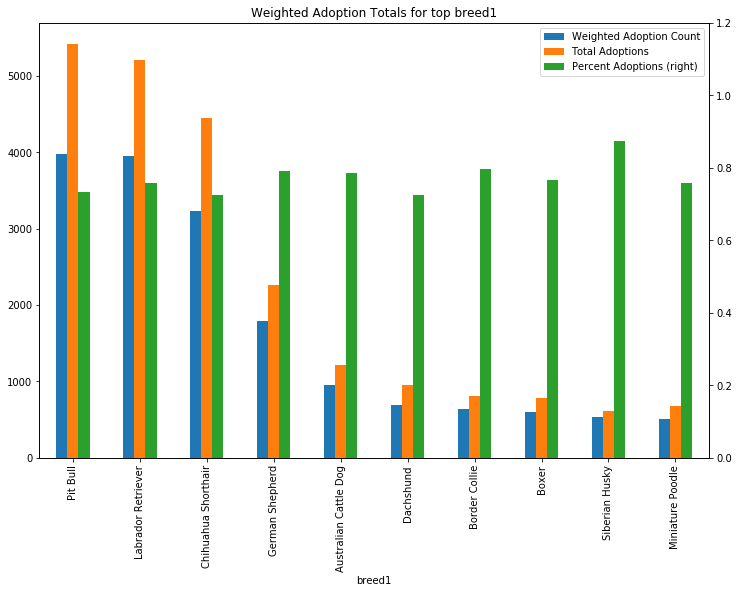

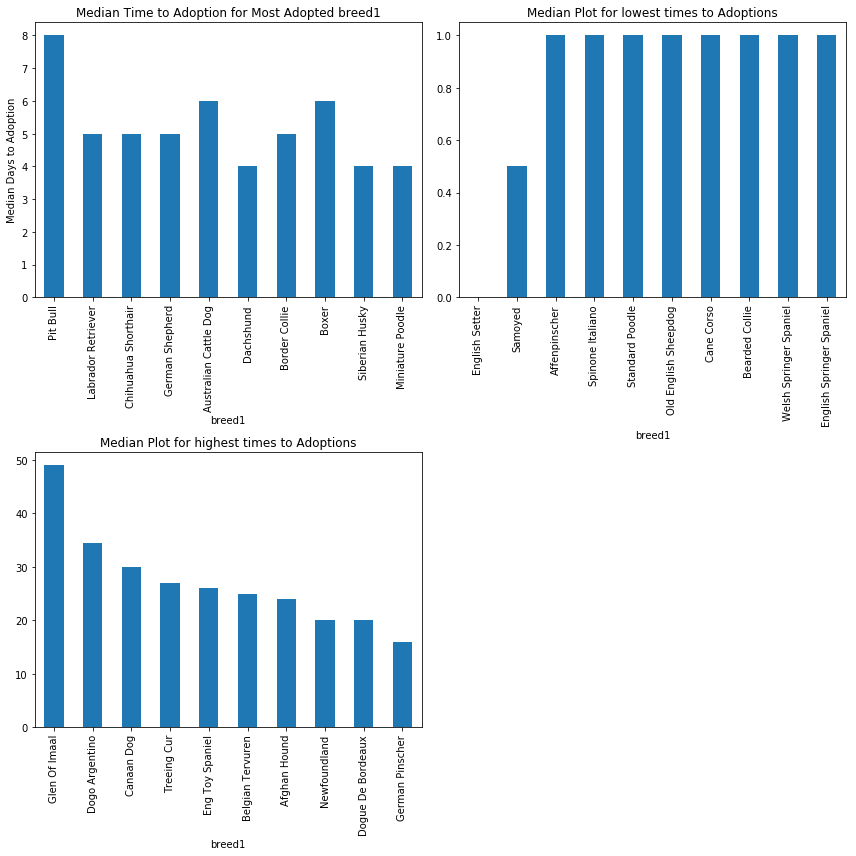


The top adoptable data.
                       Weighted Adoption Count  Total Adoptions  \
breed1                                                            
Pit Bull                           3980.634678           5423.0   
Labrador Retriever                 3952.366608           5204.0   
Chihuahua Shorthair                3225.060936           4455.0   
German Shepherd                    1791.279679           2265.0   
Australian Cattle Dog               951.332034           1210.0   
Dachshund                           690.780488            952.0   
Border Collie                       640.650149            804.0   
Boxer                               604.031128            788.0   
Siberian Husky                      537.031339            614.0   
Miniature Poodle                    513.456180            676.0   

                       Percent Adoptions  
breed1                                    
Pit Bull                        0.734028  
Labrador Retriever              0.759486 

In [22]:
#plot data for the primary breed information
plot_median_per(dogs_join,'breed1', False, False)

Secondary Breed

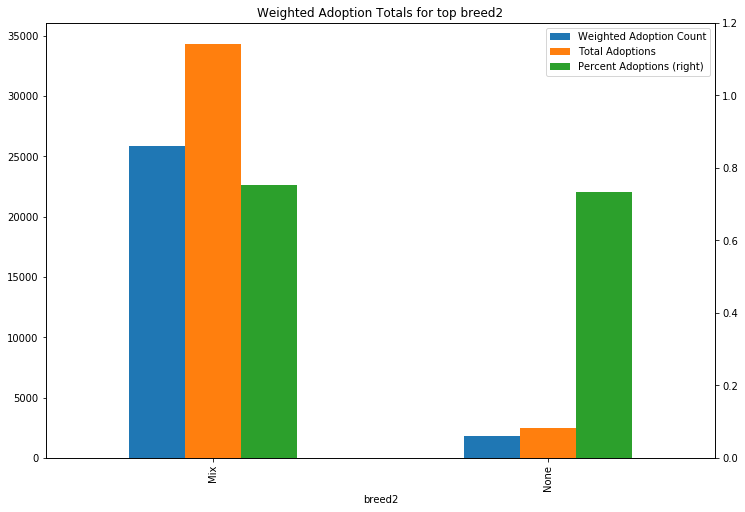

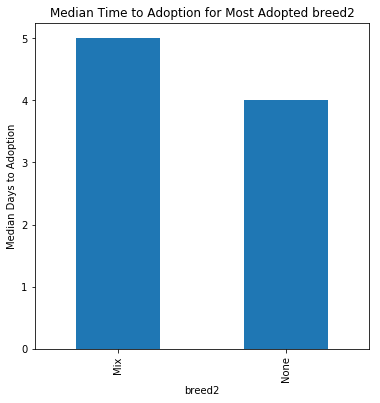


The top adoptable data.
        Weighted Adoption Count  Total Adoptions  Percent Adoptions
breed2                                                             
Mix                25822.434747          34355.0           0.751635
None                1830.204465           2496.0           0.733255


In [23]:
plot_median_per(dogs_join, 'breed2', False, True)

* It seems that the most popular adopted primary breeds are Labradors and Pitbulls, but these are also the most numerous primary breeds for intakes as well.
    * There efficiency isn't too bad either, with about 72% of the pitbulls leaving the shelter under favorable means.
        * About 75% for the labradors.
        * All the dogs in the top 10 weighted adoption count are above 70% adoptions.


* Moreover, the more exotic are lesser seen breeds are usually adopted quicker as shown in the lowest median time to adoption plot.
    * All the breeds in there are "exotic", i.e., not pitbull, labs, german shepherds, daschund, chihuahua, etc..
    * However, the longest median time to adoption breeds are also exotics, these are both outlier groups with low numbers of total adoption.  There may be other factors at play such as age, sex, etc.
    

* The median time to adoption shows that it takes a bit longer for the pitbulls to be adopted at a median time to adoption of 8 days.  
    * This still isn't too bad and the time to adoption for the top adopted breeds are all under 10 days median time to adoption.
    

* The secondary breed information suggests that mixed vs. pure breed doesn't really play an impact on the adoptions or median time to adoption.
    * Although there are substantially more mixed breed dogs in the shelter than pure breeds, which makes since if the majority of the intake type are strays, roaming free to breed with whomever, whenever.
    
* In summary, it seems paying too much attention to the rare breeds would be wasted effort, and marketing efforts should be concentrated on the most populous breeds.  Some of them have a negative stigmatism in this case. (Pitbulls, Boxers, etc.)
    
*****

**b) Age**
* Break age into groupings:
    * Puppy (0-12 Months Old)
    * Young Adult (13-36 Months Old)
    * Adult (37-72 Months Old)
    * Senior (73+ Months Old)

In [24]:
#Define a dictionary to store the age ranges
dog_ages = {'Puppy':[0,12], 'Young Adult':[13,36], 'Adult':[37,72], 'Senior':[73,np.inf]}

#now add the intake_age_cat column to dogs_join
for key, value in dog_ages.items():
    for index, row in dogs_join.iterrows():
        if value[0] <= row['intake_age'] <= value[1]:
            dogs_join.loc[index,'intake_age_cat'] = key

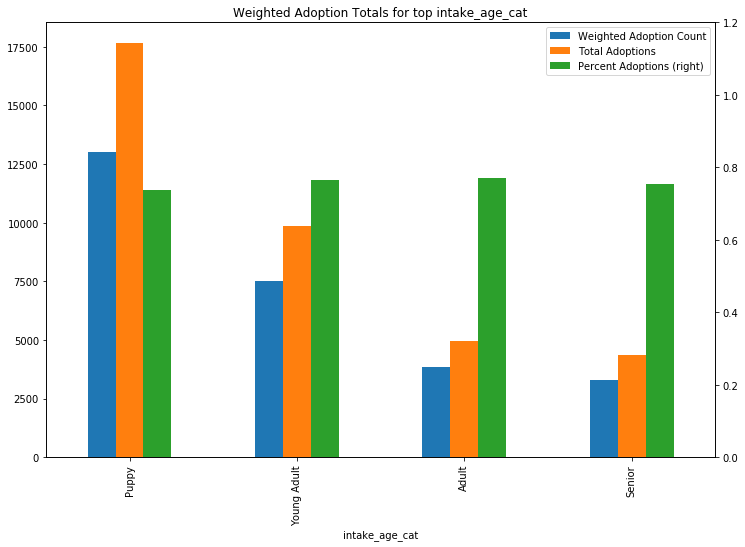

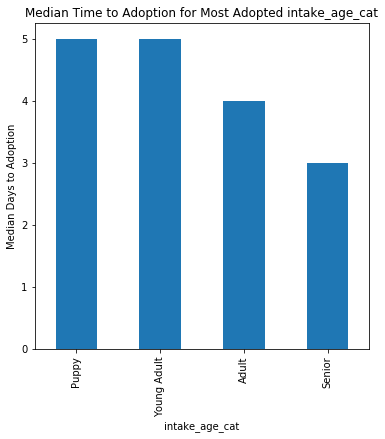


The top adoptable data.
                Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_age_cat                                                             
Puppy                      13015.192386          17658.0           0.737071
Young Adult                 7528.538789           9856.0           0.763853
Adult                       3830.889112           4977.0           0.769719
Senior                      3286.015557           4360.0           0.753673


In [25]:
#now look into plots for the Age Groups
plot_median_per(dogs_join, 'intake_age_cat', asc=False, compare=True)

* There seems to be an equal efficiency in adoptions between ages.
* Also there appears to be a negative correlation between intake age and time to adoption.

*****

**c) Color**
* Primary(Top 10)
* Secondary(Top 10)

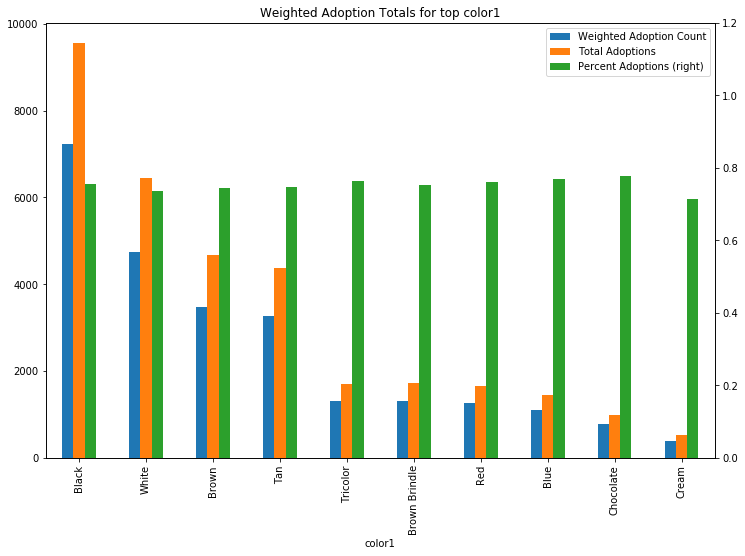

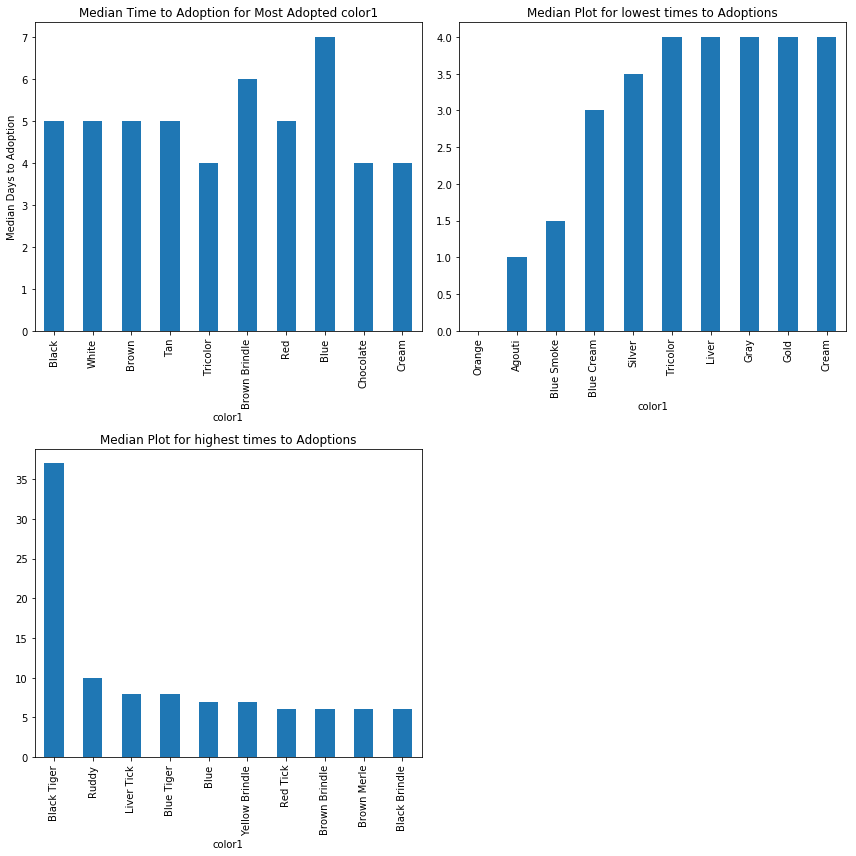


The top adoptable data.
               Weighted Adoption Count  Total Adoptions  Percent Adoptions
color1                                                                    
Black                      7218.814311           9550.0           0.755897
White                      4733.023774           6435.0           0.735513
Brown                      3468.846791           4667.0           0.743271
Tan                        3264.646938           4375.0           0.746205
Tricolor                   1294.738621           1695.0           0.763858
Brown Brindle              1294.692106           1723.0           0.751417
Red                        1248.290428           1639.0           0.761617
Blue                       1103.315142           1436.0           0.768325
Chocolate                   763.956693            985.0           0.775591
Cream                       377.653171            529.0           0.713900

The lowest median time to adoption data.
            Weighted Adoption Cou

In [26]:
#get the data for Primary
plot_median_per(dogs_join, 'color1', False, False)

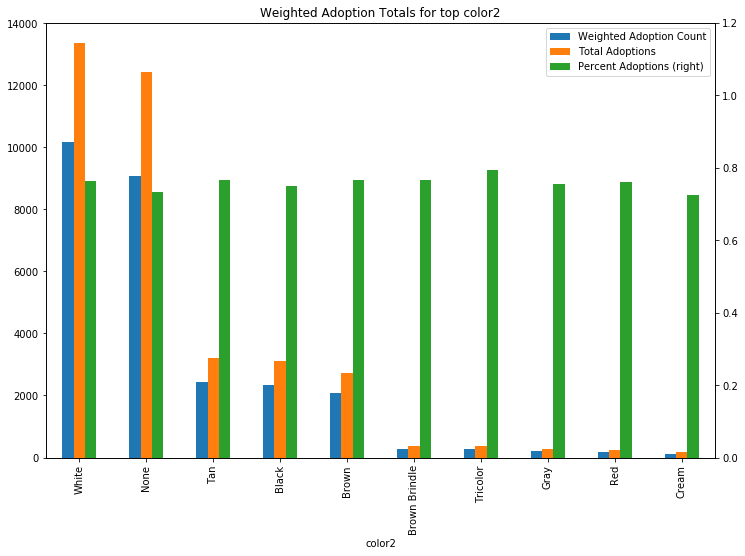

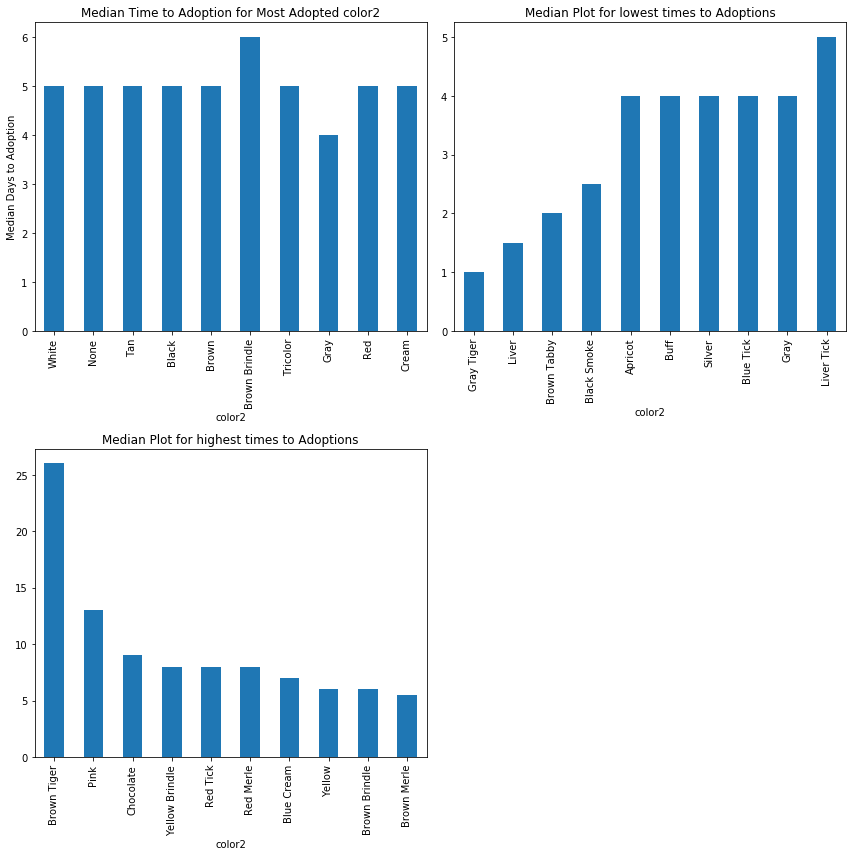


The top adoptable data.
               Weighted Adoption Count  Total Adoptions  Percent Adoptions
color2                                                                    
White                     10165.696278          13344.0           0.761818
None                       9086.023599          12410.0           0.732153
Tan                        2442.786862           3192.0           0.765284
Black                      2330.437636           3108.0           0.749819
Brown                      2093.769188           2734.0           0.765826
Brown Brindle               285.685832            373.0           0.765914
Tricolor                    284.177384            358.0           0.793792
Gray                        216.760526            287.0           0.755263
Red                         176.472131            232.0           0.760656
Cream                       124.827004            172.0           0.725738

The lowest median time to adoption data.
             Weighted Adoption Co

In [27]:
#Now for the Secondary color
plot_median_per(dogs_join, 'color2', False, False)

* It seems that neither primary color or secondary color have a big impact on adoptions or time to adoptions shown by the fact that most colors have a median time to adoption of around 5 days.
    * Also, the percent adoptions are all similar.
    
*****

**d) Gender**
* Comparison

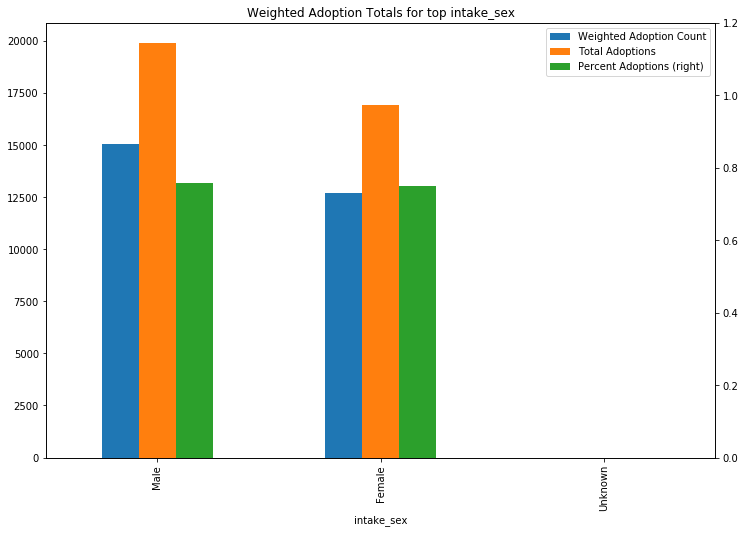

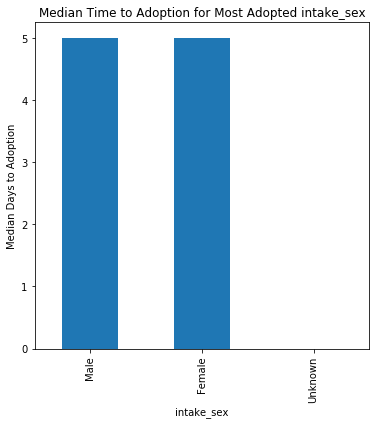


The top adoptable data.
            Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_sex                                                             
Male                   15058.333371          19876.0           0.757614
Female                 12678.578903          16924.0           0.749148
Unknown                         NaN              NaN                NaN


In [28]:
#plot the plots!
plot_median_per(dogs_join, 'intake_sex', False, True)

* The gender doesn't seem to have an appreciable impact either based on the exact same results for both males and females.

*****

**e) Fixed**
* Comparison

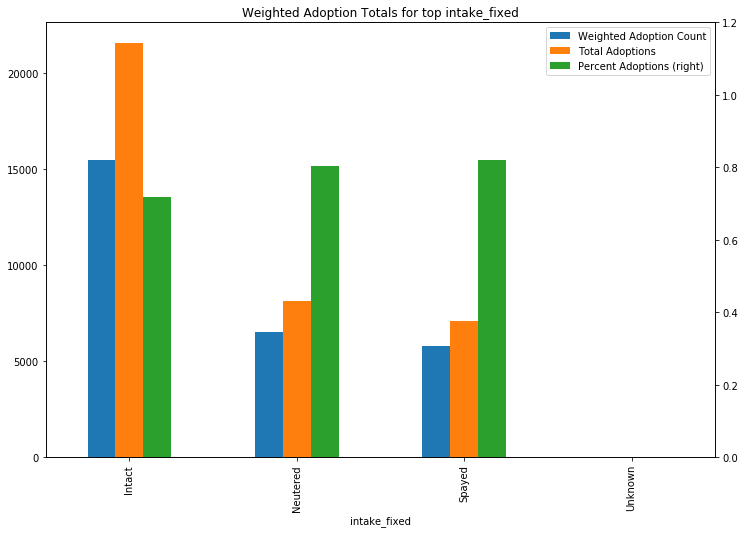

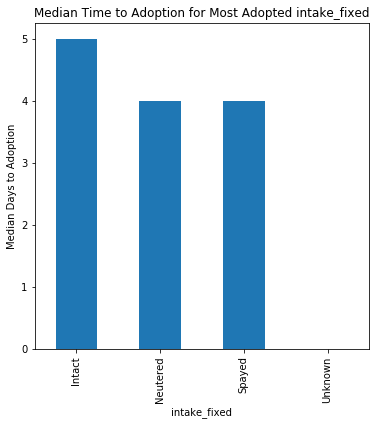


The top adoptable data.
              Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_fixed                                                             
Intact                   15481.514864          21565.0           0.717900
Neutered                  6537.677279           8144.0           0.802760
Spayed                    5818.361606           7091.0           0.820528
Unknown                           NaN              NaN                NaN


In [29]:
#plot the plots!
plot_median_per(dogs_join, 'intake_fixed', False, True)

* It seems there may be a slight favor for the fixed dogs to get adopted faster and more often then the intact intakes.
    * The median time to adoption is shorter for fixed dogs.
    * The percent adopted is slightly higher for the fixed dogs.


* This apparent time reduction to adoption could be from the fact that the recorded adopted time factors in surgery time as most dogs leave the shelter fixed even when they came in intact.

*****

**f) Seasons**
* Comparison

In [30]:
#need to break the intake dates into seasons.
#create a seasons dictionary
seasons = {'Winter':[12,1,2], 
          'Spring':[3,4,5],
          'Summer':[6,7,8],
          'Fall':[9,10,11]}

#change datetime_in to datetime datatype
dogs_join.datetime_in = pd.to_datetime(dogs_join.datetime_in)

#now label each dataframe entry with a season in the season column
for index, row in dogs_join.iterrows():
    for key, value in seasons.items():
        if row['datetime_in'].month in value:
            dogs_join.loc[index, 'intake_season'] = key


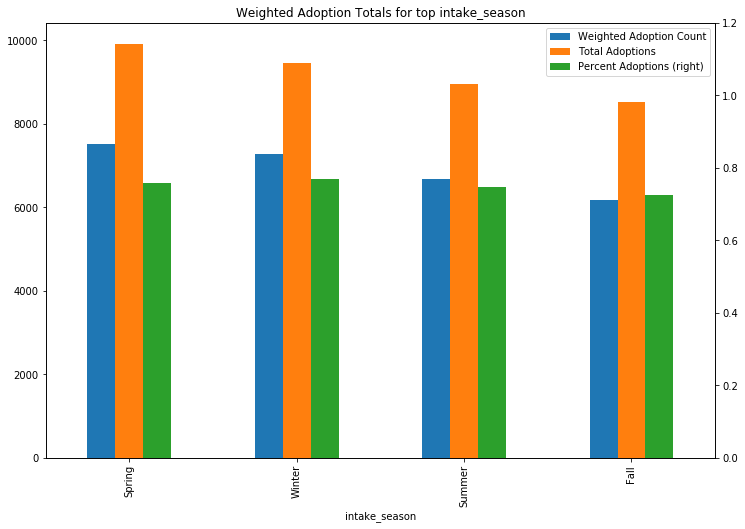

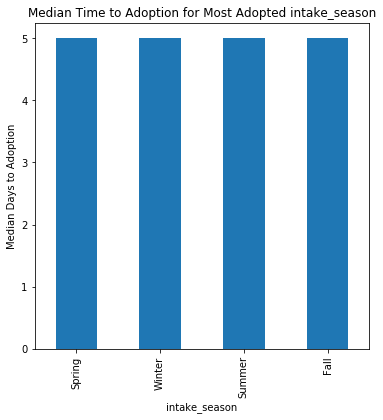


The top adoptable data.
               Weighted Adoption Count  Total Adoptions  Percent Adoptions
intake_season                                                             
Spring                     7524.733165           9922.0           0.758389
Winter                     7287.458255           9468.0           0.769694
Summer                     6676.475849           8946.0           0.746309
Fall                       6175.913543           8515.0           0.725298


In [31]:
#now plot the season adoption data
plot_median_per(dogs_join, 'intake_season', False, True)

* As shown in the time series plot at the beginning, the time of year seems to have an effect on the adoptions.
* This could be useful information, as it could mean that adoption events need to occur more often in the Fall than they currently are in order to boost adoptions in that time period.

*****

## 4. Look into Outcome Types Correlations to Intake Features
* Taking a look into what intake features such as breed and gender that end up as different shelter outcomes can draw attention to what dogs need more or less attention to end up as Adoptions.  This can also reduce the amount of dogs that get transfered and or die in shelter.  Transfers create additional strain on surrounding resources and on the pet.  Transfers are also a longer process to adoption and thus are more expensive and less efficient of a process.

* Break the outcome types into Main Groups.
    * Adoptions (Adoptions, Return to Owner, Rto-Adopt)
    * Transfers (Transfer)
    * Deaths (Died, Euthanasia, Disposal, Missing, Unknown)
    

* Look at the following intake features:
    * a) Breeds 
        * Primary (Top 10)
    * b) Gender (Comparison)

In [32]:
#filter data frames into the main groups
dog_adoptions = dogs_join.loc[(dogs_join.outcome_type == 'Adoption') | (dogs_join.outcome_type == 'Return to Owner')
                             | (dogs_join.outcome_type == 'Rto-Adopt')]
dog_transfers = dogs_join.loc[dogs_join.outcome_type == 'Transfer']
dog_deaths = dogs_join.loc[(dogs_join.outcome_type == 'Died') | (dogs_join.outcome_type == 'Euthanasia') | 
                           (dogs_join.outcome_type == 'Disposal') | (dogs_join.outcome_type == 'Missing') | 
                           (dogs_join.outcome_type == 'Unknown')]

**a) Breeds**
* Primary (Top 10)

In [33]:
#get the top10 
print('The top 10 adoptions breeds')
print(top10(dog_adoptions.breed1))
print()
print('The top 10 transfers breeds')
print(top10(dog_transfers.breed1))
print()
print('The top 10 deaths breeds')
print(top10(dog_deaths.breed1))

The top 10 adoptions breeds
Pit Bull                 5423
Labrador Retriever       5204
Chihuahua Shorthair      4455
German Shepherd          2265
Australian Cattle Dog    1210
Dachshund                 952
Border Collie             804
Boxer                     788
Miniature Poodle          676
Siberian Husky            614
Name: breed1, dtype: int64

The top 10 transfers breeds
Chihuahua Shorthair      1494
Labrador Retriever       1463
Pit Bull                 1455
German Shepherd           512
Dachshund                 327
Australian Cattle Dog     289
Shih Tzu                  260
Boxer                     194
Miniature Poodle          187
Border Collie             179
Name: breed1, dtype: int64

The top 10 deaths breeds
Pit Bull                 510
Chihuahua Shorthair      205
Labrador Retriever       185
German Shepherd           87
Boxer                     46
Australian Cattle Dog     40
Rottweiler                36
Dachshund                 33
Chow Chow                 29
Mi

* It seems that there are a lot of the top breeds in all outcome types.
* The only ones that stand out are that Shih Tzus get transfered a lot to other shelters or organizations.
    * Also, Chow Chow are on the top 10 deaths list.
    * There also aren't a lot of deaths in the shelter which is good.
    
*****

**b) Gender**
* Comparison

In [34]:
#get the comparisons
print('The gender adoptions gender comparison')
print(top10(dog_adoptions.intake_sex))
print()
print('The transfers gender comparison')
print(top10(dog_transfers.intake_sex))
print()
print('The deaths gender comparison')
print(top10(dog_deaths.intake_sex))

The gender adoptions gender comparison
Male       19876
Female     16924
Unknown       51
Name: intake_sex, dtype: int64

The transfers gender comparison
Male       5397
Female     4963
Unknown     190
Name: intake_sex, dtype: int64

The deaths gender comparison
Male       962
Female     704
Unknown     44
Name: intake_sex, dtype: int64


* The gender seems to be relatively evenly split in all outcome types.

*****

## 5. Special Case Study Return Visits
* Look into the return visit cases income and outcome types.
* Return visits can usurp resources and take away efficiency from the shelter operations ability to serve new pets.  Identifying potential return cases and the circumstances around them can help in changing policy or procedures to prevent them.

The total intake type counts for comparison


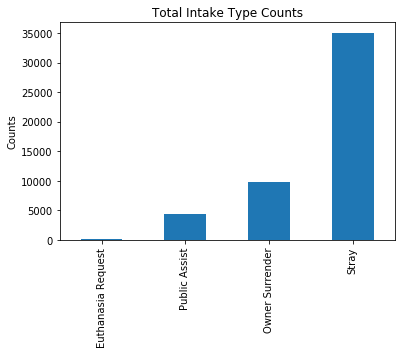


The intake type for return visits


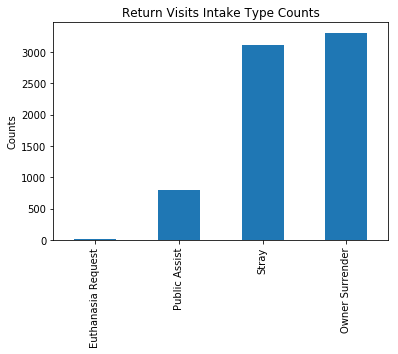


The total outcome type counts for comparison


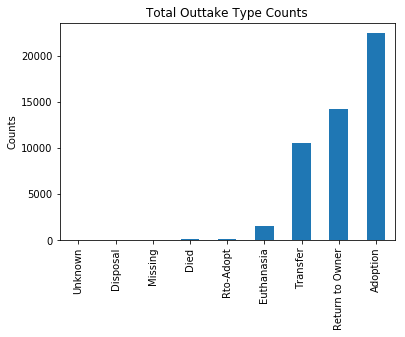


The outcome type for return visits


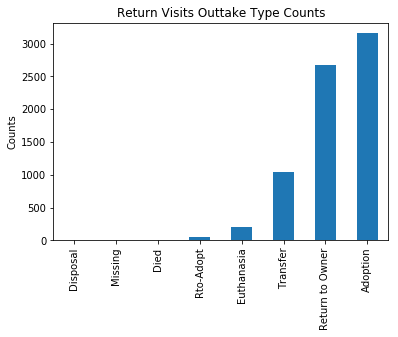

In [35]:
#get return visits by filtering on intake > 1 in dogs_join
return_visits = dogs_join.loc[dogs_join.intake > 1]

#now plot the value counts for the outcome types and intake types
print('The total intake type counts for comparison')
dogs_join.intake_type.value_counts().sort_values().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Total Intake Type Counts')
plt.show()
print()

print('The intake type for return visits')
return_visits.intake_type.value_counts().sort_values().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Return Visits Intake Type Counts')
plt.show()
print()

print('The total outcome type counts for comparison')
dogs_join.outcome_type.value_counts().sort_values().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Total Outtake Type Counts')
plt.show()
print()

print('The outcome type for return visits')
return_visits.outcome_type.value_counts().sort_values().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Return Visits Outtake Type Counts')
plt.show()

* It seems that a fair amount of return visits are due to owners giving there pets up and trying to reclaim them.  
    * Maybe trying to utilize the shelter as "free boarding", but as shown earlier a low percentage of owner surrenders end up later as return to owners.
    * Also, this would eat up a lot of valuable shelter resources and potentially cause lots of unnecessary heartbreak.
* Also, a lot of return visit intakes are strays suggesting that the something better could be done to screen potential adopters or more emphasis placed on educating new potential pet owners before adopting.     
*****

## 6. A little Time Series Analysis
* Going to look at the trends of Adoptions over time for the Top 5 breeds Identified earlier.
    * Pit Bull                          
    * Labrador Retriever                
    * Chihuahua Shorthair             
    * German Shepherd                    
    * Australian Cattle Dog
* Breeds seem to be the most interesting statistically to look by first inspection.
* By looking at the breed adoptions over time a general overview can be obtained of when adoption/marketing efforts can be intensified for certain breeds to get them adopted sooner and more reliably.  

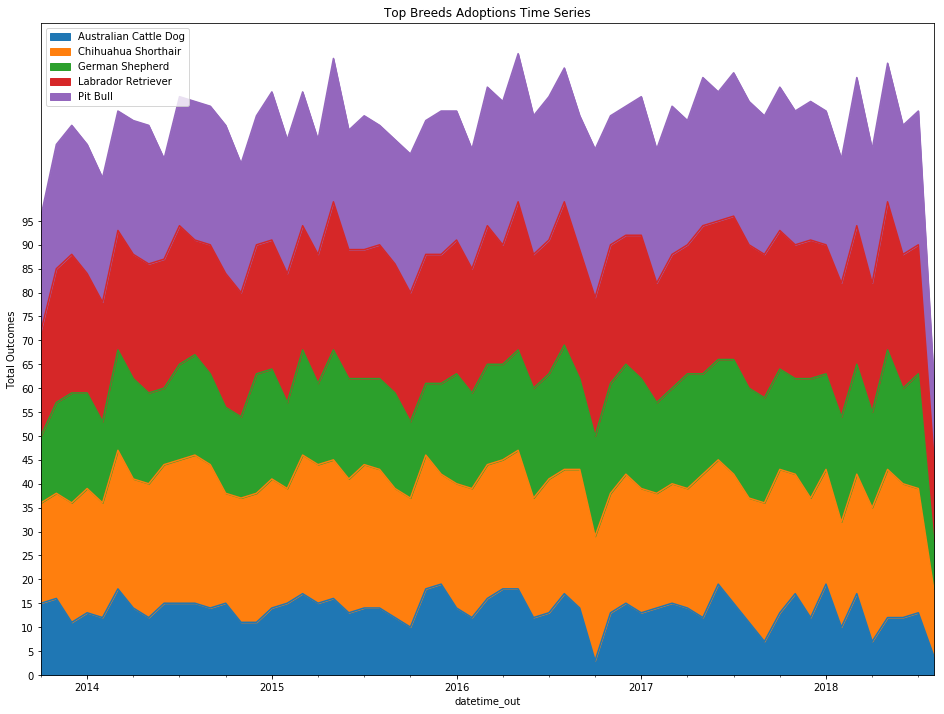

In [36]:
#Now we need to take the adoptions dataframe and set the datetime_in as the index
adoption_by_time = dog_adoptions.set_index('datetime_out',drop=True)
adoption_by_time.index = pd.to_datetime(adoption_by_time.index)
adoption_by_time.sort_index()

#select out only the breeds above
adoption_by_time_top_breeds = adoption_by_time.loc[(adoption_by_time.breed1 == 'Pit Bull') |  
                                                  (adoption_by_time.breed1 == 'Labrador Retriever') | 
                                                  (adoption_by_time.breed1 == 'Chihuahua Shorthair') | 
                                                  (adoption_by_time.breed1 == 'German Shepherd') | 
                                                  (adoption_by_time.breed1 == 'Australian Cattle Dog')]

#now pivot with index as the datetime_in and the breeds as the columns
pivot_time = pd.pivot_table(adoption_by_time_top_breeds, index=adoption_by_time_top_breeds.index, 
                            columns='breed1', values='color1', aggfunc='count')

#resample monthly
pivot_time = pivot_time.resample('M').count()

#plot pivot_time
pivot_time.plot(kind='area', stacked=True, figsize=(16,12))
#x_labels = [date.strftime('%B %Y') for date in pivot_time.index]
plt.title('Top Breeds Adoptions Time Series')
plt.ylabel('Total Outcomes')
plt.yticks(range(0, 100, 5))
#plt.xticks(x_labels, x_labels, rotation=90)
plt.legend(loc='best')
plt.show()
plt.show()

* Interestingly it looks like they may run adoption events or something in the fall and spring.  A lot of the peaks seem cyclical and line up well with fall and spring months.
    * Or this could just be people feel like adopting more before and after winter.
    * In this case, efforts could be increased to even out the adoptions for all times of the year.
    
* More in depth looks could be done into time series analysis for other features.
    
****

## 7.  Special Case Study Dogs still in the Shelter.
* Let's take a look at the features and demographic of the dogs still in the shelter.
* These are identified as the dogs that don't have any outtake data.
* We will take a look at the following features for the dogs in the shelter.
    * a) Primary Breeds (Top 10)
    * b) Intake Age (Distribution)
    * c) Gender (Comparison)
    * d) Fixed (Comparison)
* Moreover, we will compare them to the features for all intakes and the dogs that were adopted feature intakes.

**a) Primary Breeds (Top 10)**

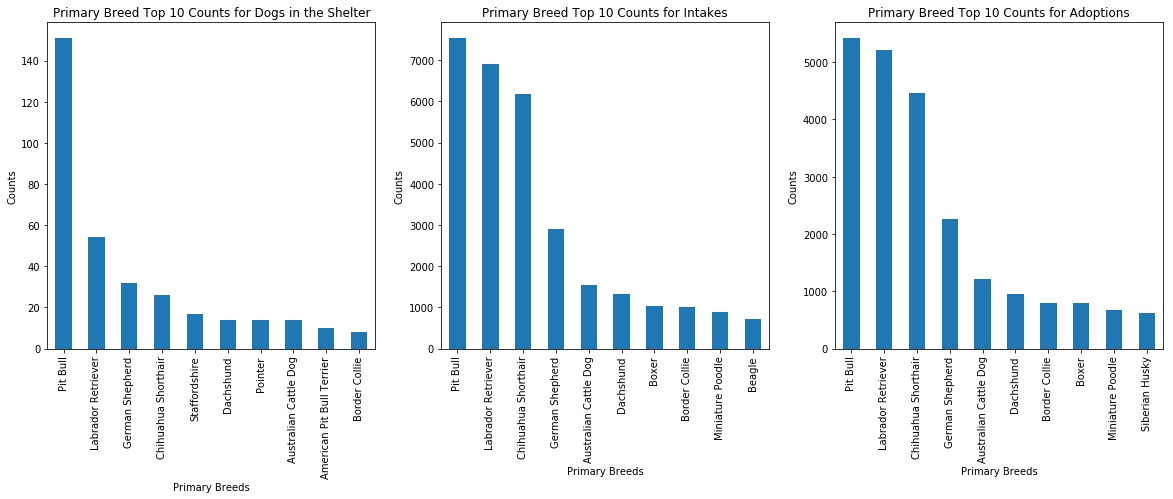

In [63]:
#single out the dogs still in the shelter
dogs_shelter = dogs_join.loc[dogs_join.shelter_time.isnull()]

# Take a look at the top 10 primary breeds
#plot top10 of each
top10(dogs_shelter.breed1)
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
top10(dogs_shelter.breed1).plot(kind='bar', label='shelter')
plt.xlabel('Primary Breeds')
plt.ylabel('Counts')

plt.title('Primary Breed Top 10 Counts for Dogs in the Shelter')

plt.subplot(1,3,2)
top10(dogs_join.breed1).plot(kind='bar', label='intake')
plt.xlabel('Primary Breeds')
plt.ylabel('Counts')
plt.title('Primary Breed Top 10 Counts for Intakes')

plt.subplot(1,3,3)
top10(dog_adoptions.breed1).plot(kind='bar', label='adoptions')
plt.xlabel('Primary Breeds')
plt.ylabel('Counts')
plt.title('Primary Breed Top 10 Counts for Adoptions')

plt.show()

* It seems that for the most part what comes in the shelter is moved through the shelter.  Most of top 10 breed intakes are moved through the shelter as adoptions and not as other outcome types.
* Approximately 2000 of each top primary breed are not adopted and not in the shelter.
    * This suggestst that there is still some room for improvement in getting dogs adopted.
* The fact that most of the same breeds are in the shelter currently suggests that there is not a overwhelming amount of one breed that gets "stuck" in the shelter or ends up overwhelmingly as the other outcome types.
    * However, the Staffordshire terriers show up in the shelter top 10 but not in the intakes or the adoptions.  This suggests that the shelter might keep some of this breed longer than others.  Maybe, they are not adopted as often and end up as transfers or deaths.  
        * From my time in shelters (not the one for this data), I've noticed that most of the dogs are labeled as staffordshire and they will remain in the shelter for months on end.

**b) Intake Age (Distributions)**

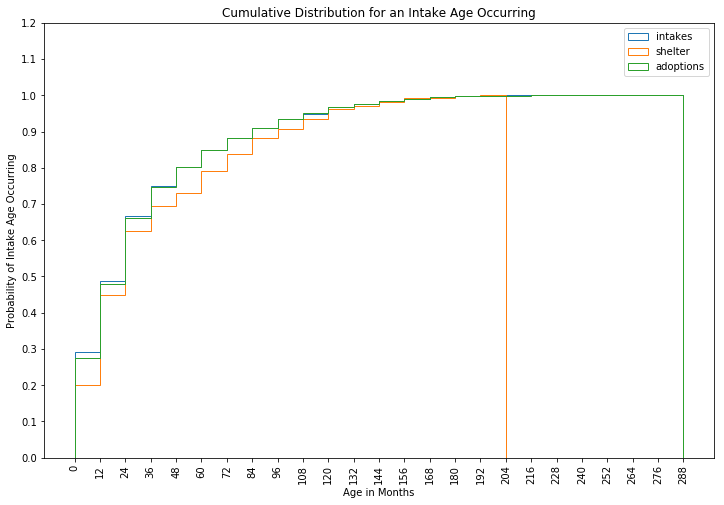

In [71]:
#plot the cdf for adoptions, intakes, and shelter
plt.figure(figsize=(12,8))
intakes_ages = dogs_join.intake_age
shelter_ages = dogs_shelter.intake_age
adoptions_ages = dog_adoptions.intake_age
intakes_ages.plot(kind='hist', normed = True, cumulative=True, histtype='step', 
                  bins=range(0,int(intakes_ages.max())+12,12), label='intakes')
shelter_ages.plot(kind='hist', normed=True, cumulative=True, histtype='step', 
                  bins=range(0,int(shelter_ages.max())+12,12), label='shelter')
adoptions_ages.plot(kind='hist', normed=True, cumulative=True, histtype='step', 
                    bins=range(0,int(adoptions_ages.max())+12,12), label='adoptions')
plt.xlabel('Age in Months')
plt.ylabel('Probability of Intake Age Occurring')
plt.xticks(range(0,int(ages.max())+12,12), rotation=90)
plt.yticks(np.arange(0,1.3,0.1))
plt.title('Cumulative Distribution for an Intake Age Occurring')
plt.legend(loc='best')
plt.show()

* The age distribution for intakes and adoptions seem mostly the same.  However, the intakes seem to be slightly older in general than the adoptions.  This suggests that younger dogs are adopted more than older dogs.
* The age distribution for the dogs in the shelter currently is quite different from the intakes and the adoptions.
    * The max age is much less than the max age for adoptions and intakes.  
    * However, the age at 80% is higher than the age at 80% than the adoptions and the intakes.
        * This suggests once again that younger dogs are adopted more then older dogs.
        
**c) Gender (Comparison)**

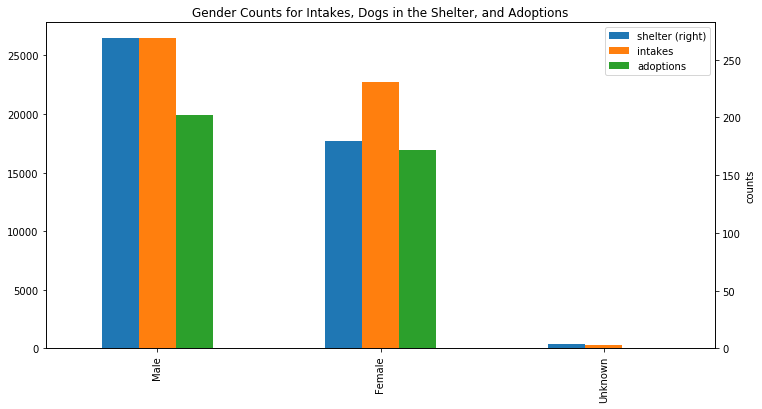

In [96]:
#plot the Gender distributions for adoptions, shelter, and intakes
gender_comp = pd.DataFrame({'shelter':dogs_shelter.intake_sex.value_counts(),
                            'intakes':dogs_join.intake_sex.value_counts(),
                            'adoptions':dog_adoptions.intake_sex.value_counts()},
                           columns=['shelter','intakes','adoptions'])


gender_comp.plot(kind='bar', secondary_y=['shelter'], figsize=(12,6))
plt.xlabel('gender')
plt.ylabel('counts')
plt.title('Gender Counts for Intakes, Dogs in the Shelter, and Adoptions')
plt.show()

* It seems that the gender doesn't lean to one group or the other.

**d) Fixed (Comparison)**

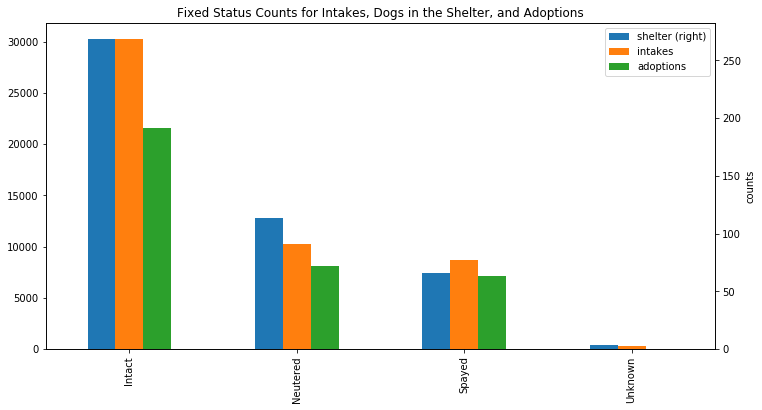

In [95]:
fixed_comp = pd.DataFrame({'shelter':dogs_shelter.intake_fixed.value_counts(),
                            'intakes':dogs_join.intake_fixed.value_counts(),
                            'adoptions':dog_adoptions.intake_fixed.value_counts()},
                           columns=['shelter','intakes','adoptions'])


fixed_comp.plot(kind='bar', secondary_y=['shelter'], figsize=(12,6))
plt.xlabel('fixed status')
plt.ylabel('counts')
plt.title('Fixed Status Counts for Intakes, Dogs in the Shelter, and Adoptions')
plt.show()

* It seems that there is not a major difference between the groups fixed status.  Most are intact.
* However, as shown earlier most of the dogs leave the shelter fixed, which is most shelters standard policy.

***

* Overall, it seems that the main differences are in breed and age for dogs in the shelter versus the other groups of dogs.
    * More comparisons could be done later with more time and effort.

*****

# Next step is to do some statistical testing.

In [37]:
import json
#save some of the dataframes generated in this notebook
dogs_join.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_join.csv', index=False)
dog_adoptions.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_adoptions.csv', index=False)
dog_transfers.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_transfers.csv', index=False)
dog_deaths.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_deaths.csv', index=False)
return_visits.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/return_visits.csv', index=False)

#save some of the dictionaries as json
with open('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dog_ages.json', 'w') as fp:
    json.dump(dog_ages, fp)
with open('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/seasons.json','w') as fp:
    json.dump(seasons, fp)